In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib

from PIL import Image

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

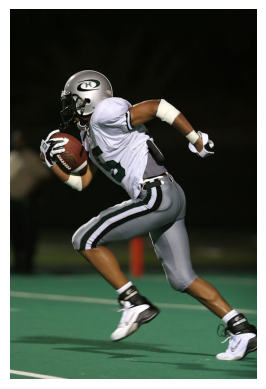

In [3]:
image = Image.open('input/image_1.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
# Load object detection model.
person_image_processor = AutoProcessor.from_pretrained('PekingU/rtdetr_r50vd_coco_o365')
person_model = RTDetrForObjectDetection.from_pretrained(
    'PekingU/rtdetr_r50vd_coco_o365', 
    device_map=device
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
def detect_objects(image):
    """
    :param image: Image in PIL image format.

    Returns:
        person_boxes: Bboxes of persons in [x, y, w, h] format.
    """
    inputs = person_image_processor(
        images=image, return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = person_model(**inputs)

    target_sizes = torch.tensor([(image.height, image.width)])
    
    results = person_image_processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=0.3
    )
    
    # Extract the first result, as we can pass multiple images at a time.
    result = results[0]
    
    # In COCO dataset, humans labels have index 0.
    person_boxes_xyxy = result['boxes'][result['labels'] == 0]
    person_boxes_xyxy = person_boxes_xyxy.cpu().numpy()
    
    # Convert boxes from (x1, y1, x2, y2) to (x1, y1, w, h) format.
    person_boxes = person_boxes_xyxy.copy()
    person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
    person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]
    print(person_boxes)

    return person_boxes

In [6]:
# Load ViTPose model.
image_processor = AutoProcessor.from_pretrained(
    'usyd-community/vitpose-base-simple'
)
model = VitPoseForPoseEstimation.from_pretrained(
    'usyd-community/vitpose-base-simple', device_map=device
)

In [7]:
def detect_pose(image, person_boxes):
    """
    :param image: Image in PIL image format.
    :param person_bboxes: Batched person boxes in [[x, y, w, h], ...] format.
    """
    inputs = image_processor(
        image, boxes=[person_boxes], return_tensors='pt'
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    pose_results = image_processor.post_process_pose_estimation(
        outputs, boxes=[person_boxes]
    )
    image_pose_result = pose_results[0]
    
    print(image_pose_result)

    return image_pose_result

In [8]:
bboxes = detect_objects(image)
image_pose_result = detect_pose(image, bboxes)

[[7.5910889e+01 1.5777600e+02 5.6469287e+02 7.5787720e+02]
 [4.3792725e-02 3.1021429e+02 1.0418881e+02 3.7794379e+02]]
[{'keypoints': tensor([[153.4705, 255.6327],
        [155.2591, 239.2415],
        [155.1221, 239.0368],
        [174.0532, 239.6201],
        [233.1174, 210.8382],
        [248.1761, 272.3109],
        [209.8787, 327.9704],
        [382.1495, 254.0411],
        [188.7489, 446.8465],
        [476.0375, 331.8938],
        [124.9601, 410.1974],
        [381.2399, 492.1115],
        [417.8311, 488.2391],
        [197.9209, 600.3510],
        [446.0930, 698.2394],
        [318.3506, 761.6322],
        [588.0345, 820.4767]]), 'scores': tensor([0.7639, 0.7476, 0.6793, 0.8779, 0.6814, 0.9280, 0.7452, 0.9129, 0.9302,
        0.9398, 0.7560, 0.7871, 0.6811, 0.9874, 0.9644, 0.8854, 0.8639]), 'labels': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'bbox': tensor([358.2573, 536.7146, 360.8099, 540.4514])}, {'keypoints': tensor([[ 19.3639, 342.5414],

In [9]:
# Print results in more human-readable format.
for i, person_pose in enumerate(image_pose_result):
    print(f'Person #{i}')
    for keypoint, label, score in zip(
        person_pose['keypoints'], person_pose['labels'], person_pose['scores']
    ):
        keypoint_name = model.config.id2label[label.item()]
        x, y = keypoint
        print(f' - {keypoint_name}: x={x.item():.2f}, y={y.item():.2f}, score={score.item():.2f}')

Person #0
 - Nose: x=153.47, y=255.63, score=0.76
 - L_Eye: x=155.26, y=239.24, score=0.75
 - R_Eye: x=155.12, y=239.04, score=0.68
 - L_Ear: x=174.05, y=239.62, score=0.88
 - R_Ear: x=233.12, y=210.84, score=0.68
 - L_Shoulder: x=248.18, y=272.31, score=0.93
 - R_Shoulder: x=209.88, y=327.97, score=0.75
 - L_Elbow: x=382.15, y=254.04, score=0.91
 - R_Elbow: x=188.75, y=446.85, score=0.93
 - L_Wrist: x=476.04, y=331.89, score=0.94
 - R_Wrist: x=124.96, y=410.20, score=0.76
 - L_Hip: x=381.24, y=492.11, score=0.79
 - R_Hip: x=417.83, y=488.24, score=0.68
 - L_Knee: x=197.92, y=600.35, score=0.99
 - R_Knee: x=446.09, y=698.24, score=0.96
 - L_Ankle: x=318.35, y=761.63, score=0.89
 - R_Ankle: x=588.03, y=820.48, score=0.86
Person #1
 - Nose: x=19.36, y=342.54, score=0.91
 - L_Eye: x=25.64, y=334.87, score=0.89
 - R_Eye: x=14.93, y=334.33, score=0.90
 - L_Ear: x=37.89, y=339.98, score=0.86
 - R_Ear: x=6.98, y=340.12, score=0.84
 - L_Shoulder: x=55.36, y=385.94, score=0.88
 - R_Shoulder: x=

In [10]:
edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6), (11, 12)
]

In [11]:
def draw_keypoints(outputs, image):
    """
    :param outputs: Outputs from the keypoint detector.
    :param image: Image in PIL Image format.

    Returns:
        image: Annotated image Numpy array format.
    """
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    # the `outputs` is list which in-turn contains the dictionaries 
    for i, pose_result in enumerate(outputs):
        keypoints = pose_result['keypoints'].cpu().detach().numpy()
        # proceed to draw the lines if the confidence score is above 0.9
        keypoints = keypoints[:, :].reshape(-1, 2)
        for p in range(keypoints.shape[0]):
            # draw the keypoints
            cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                        3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            # uncomment the following lines if you want to put keypoint number
            # cv2.putText(image, f'{p}', (int(keypoints[p, 0]+10), int(keypoints[p, 1]-5)),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        for ie, e in enumerate(edges):
            # get different colors for the edges
            rgb = matplotlib.colors.hsv_to_rgb([
                ie/float(len(edges)), 1.0, 1.0
            ])
            rgb = rgb*255
            # join the keypoint pairs to draw the skeletal structure
            cv2.line(image, (int(keypoints[e, 0][0]), int(keypoints[e, 1][0])),
                    (int(keypoints[e, 0][1]), int(keypoints[e, 1][1])),
                    tuple(rgb), 2, lineType=cv2.LINE_AA)
    return image

In [12]:
result = draw_keypoints(image_pose_result, image)

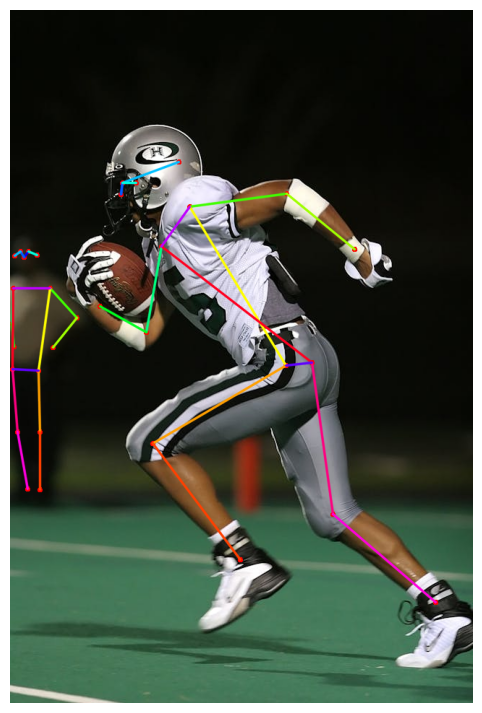

In [17]:
plt.figure(figsize=(12, 9))
plt.imshow(result[..., ::-1])
plt.axis('off')
plt.show()